## Learning Linear Dyamical Systems via Spectral Filtering

The paper describes a method the identify linear dynamic systems (LDS) using known inputs and outputs. The LDS is described in terms of its eigen frequencies. By using a Hankel matrix what descibes a finite range of eigen values (aka scaling factors) and eigen vectors (aka filters) and minimizing the loss function using gradient decent. 

#### Findings
Results very sensitive for model parameters. Learning rate needs to be as high as possible to get a proper response. If learning rate is to log, the y(t-1) seems to dominate the output.
Scaling with Rm influences results is choice too low and acts as a tuning parameter.

Response on step function is to be in the reverse direction.

#### Tests
Some test are generated from models defined in the state space. The results of the paper are not reproduced because the data used by the autors is not avaibale.

In [1]:
from scipy.linalg import eig, eigvals, norm
import scipy.signal
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# %matplotlib inline

In [3]:
class LDS:
    def __init__(self, k, lr, Rm=100):
        
        # number of eigen vectors used
        self.k = k
        
        # learning rate
        self.lr = lr
        
        # upper bound of Frobenius norm
        self.Rm = Rm
        
        # compute the k eigen vectors and scaled eigenvalues of the Hankel matrix
        self.Zij(k, k)
        
    def lens(self, arr, s, e=None):
        """ exposes arr from t = s,..,e
            if e is None, only the value at t is s is returned
        """
        offset = self.k-1
        if e == None:
            result = arr[s+offset,:].reshape(-1,1)
        elif e < s:
            result = np.flipud(arr[e+offset+1:s+offset+1,:])
        else:
            result = arr[s+offset:e+offset,:]
        return result
    
    def Zij(self, nr_rows, nr_cols):
        """Calculate the eigenvectors and eigenvalues of the Hankel matrix"""
        zij = np.array([ [2/(np.power(i+j, 3) - (i+j)) for j in range(1, nr_cols+1)] for i in range(1, nr_rows+1)])
        self.eig_vals, self.eig_vecs = eig(zij)
        self.scale_vals = np.power(self.eig_vals, 0.25)

    def preprocess(self, arr):
        """Prepend k zeros to the array"""
        pre = np.zeros((self.k, arr.shape[1]))
        return arr.shape[1], np.concatenate((pre, arr))

    def fit(self, x_raw, y_raw):
        """Train the model using x and y"""
        
        # prefix the input and output matrices with the appropriate 
        # number of zeros thus when t < 0, x(t) = y(t)= 0
        # n and m are the dimenstions of x and y resp.
        n, x = self.preprocess(x_raw)
        m, y = self.preprocess(y_raw)
        T = len(x_raw)

        # calculate size of Xtilde
        k_accent = n*self.k + 2*n + m
        
        # initialize M
        # the article does not provide any clue on the best initialisation
        # alternative are:
        #      self.M = np.zeros((m, k_accent))
        #      self.M = np.ones((m, k_accent))
        np.random.seed(0)
        self.M = np.random.rand(m, k_accent)

        # initialize history for logging the loss
        self.hist = np.array([])

        # initialize array for storing predicted y's
        _, yhat = self.preprocess(np.zeros((1, m)))
        
        for t in range(1, T):

            # compute the dot product of the eigen vectors and x(t), where t=t-1, ... t-1-k
            # eq (5)
            Vx = np.dot(self.eig_vecs.T, self.lens(x, t-1, t-(1+self.k)))
            Xtilde_ij = np.einsum('ij,i->ij', Vx, self.scale_vals).reshape(-1,1)
            Xtilde = np.concatenate((Xtilde_ij, 
                                     self.lens(x, t-1), 
                                     self.lens(x, t), 
                                     self.lens(y, t-1)), axis=0)

            # predict y
            yhat_t = np.dot(self.M, Xtilde)
            
            # store y^
            yhat = np.concatenate((yhat, yhat_t.reshape(1,-1)), axis=0)
            
            # compute loss
            y_t = self.lens(y, t)
            deltay = yhat_t - y_t # note: the implementation deviates here from the article, line 8 of Algo
            loss = (deltay**2).mean()

            # gradient update 
            self.M = self.M - 2*self.lr*np.outer(deltay, Xtilde)

            # logging the loss
            self.hist = np.append(self.hist, loss)

            # normalize M if necessary
            frob_norm = norm(self.M, 'fro')
            if frob_norm > self.Rm:
                self.M = self.Rm/frob_norm*self.M
                
        return yhat[self.k+1:]

/usr/local/lib/python3.5/dist-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


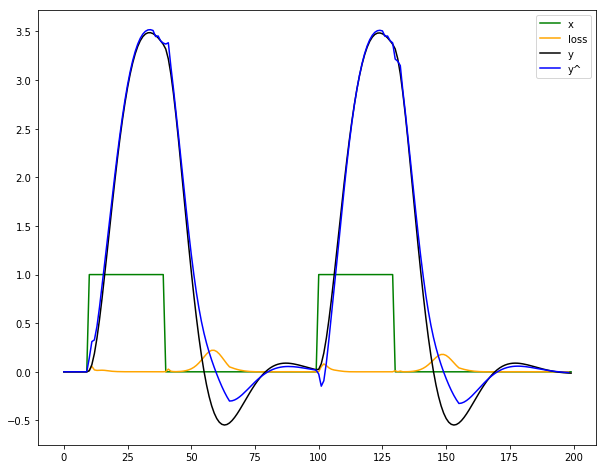

In [4]:
# Test 1
response = np.genfromtxt('./test1.csv', delimiter=",")
x = response[:,1].reshape(-1,1)
y = response[:,2].reshape(-1,1)

sf = LDS(k=25, lr=5.e-2)

y_pred = sf.fit(x, y)
plt.figure(figsize=(10,8))
plt.clf()
plt.plot(x, c='green', label='x')
plt.plot(sf.hist, c='orange', label='loss')
plt.plot(y, c='black', label='y')
plt.plot(y_pred, c='blue', label='y^')
plt.legend()
plt.show()

/usr/local/lib/python3.5/dist-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


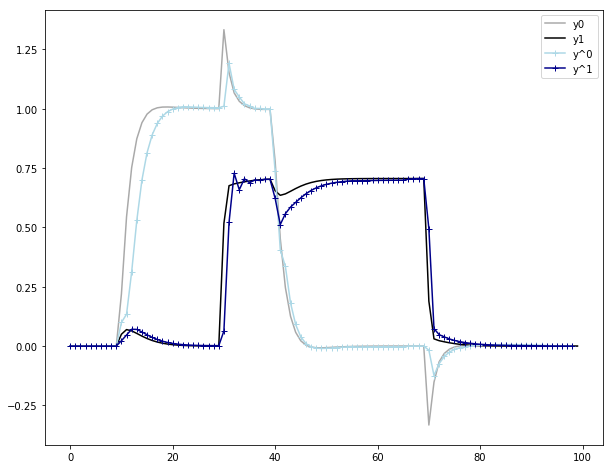

In [5]:
# Test 2
response = np.genfromtxt('./test2.csv', delimiter=",")
x = response[:,1:3]
y = response[:,3:5]

sf = LDS(k=25, lr=8.e-2, Rm=0.6)

y_pred = sf.fit(x, y)
plt.figure(figsize=(10,8))
plt.clf()
# plt.plot(x[:,0], c='lightgreen', label='x')
# plt.plot(x[:,1], c='darkgreen', label='x')
# plt.plot(sf.hist, c='orange', label='loss')
plt.plot(y[:,0], c='darkgrey', label='y0')
plt.plot(y[:,1], c='black', label='y1')
plt.plot(y_pred[:,0], c='lightblue', label='y^0', marker='+')
plt.plot(y_pred[:,1], c='darkblue', label='y^1', marker='+')
plt.legend()
plt.show()

/usr/local/lib/python3.5/dist-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


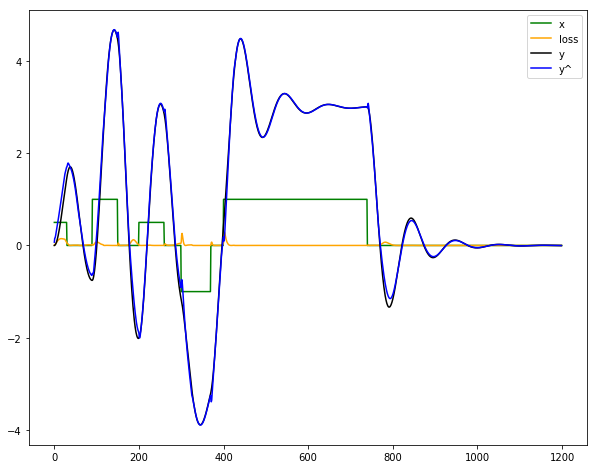

In [6]:
# Test 3
response = np.genfromtxt('./test3.csv', delimiter=",")
x = response[:,1].reshape(-1,1)
y = response[:,2].reshape(-1,1)

sf = LDS(k=25, lr=1.e-2, Rm=100)

y_pred = sf.fit(x, y)
plt.figure(figsize=(10,8))
plt.clf()
plt.plot(x, c='green', label='x')
plt.plot(sf.hist, c='orange', label='loss')
plt.plot(y, c='black', label='y')
plt.plot(y_pred, c='blue', label='y^')
plt.legend()
plt.show()

/usr/local/lib/python3.5/dist-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


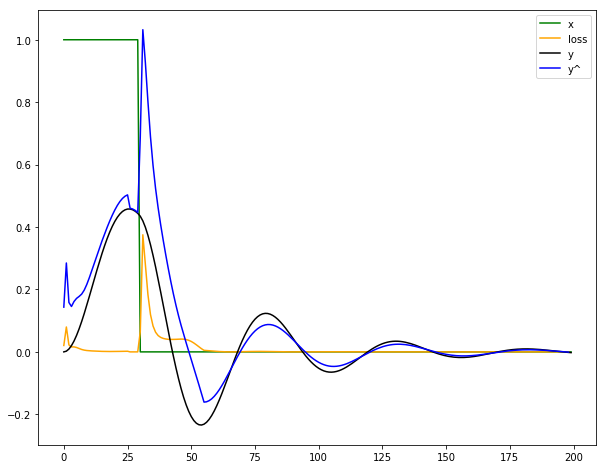

In [7]:
# Test 4
response = np.genfromtxt('./test4.csv', delimiter=",")
x = response[:,1].reshape(-1,1)
y = response[:,2].reshape(-1,1)

sf = LDS(k=25, lr=1.e-1, Rm=100)

y_pred = sf.fit(x, y)
plt.figure(figsize=(10,8))
plt.clf()
plt.plot(x, c='green', label='x')
plt.plot(sf.hist, c='orange', label='loss')
plt.plot(y, c='black', label='y')
plt.plot(y_pred, c='blue', label='y^')
plt.legend()
plt.show()

/usr/local/lib/python3.5/dist-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


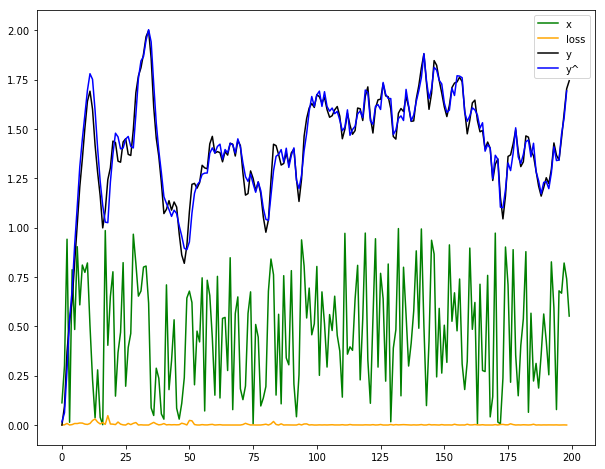

In [8]:
# Test 5
response = np.genfromtxt('./test5.csv', delimiter=",")
x = response[:,1].reshape(-1,1)
y = response[:,2].reshape(-1,1)

sf = LDS(k=25, lr=1.e-1, Rm=100)

y_pred = sf.fit(x, y)
plt.figure(figsize=(10,8))
plt.clf()
plt.plot(x, c='green', label='x')
plt.plot(sf.hist, c='orange', label='loss')
plt.plot(y, c='black', label='y')
plt.plot(y_pred, c='blue', label='y^')
plt.legend()
plt.show()